# Model 

# Generate features from event table

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This statement allow to display plot without asking to
%matplotlib inline

# Always make it pretty.
plt.style.use('seaborn')

In [2]:
# Load play data
df_play = pd.read_csv('play_event_table.csv')

In [3]:
df_play.head()

,uid,event_type,date,song_id,churn
0,168130596.0,play,2017-05-12,450882.0,0
1,168139046.0,play,2017-05-12,3418524.0,0
2,168156407.0,play,2017-05-12,1350815.0,0
3,168236980.0,play,2017-05-12,20275342.0,0
4,168074596.0,play,2017-05-12,5595443.0,0


In [4]:
# Load download data
df_down = pd.read_csv('down_event_table.csv')

In [5]:
df_down.head()

,uid,event_type,date
0,167819030.0,download,2017-03-30
1,167819030.0,download,2017-03-30
2,167819030.0,download,2017-03-30
3,167819030.0,download,2017-03-30
4,167819030.0,download,2017-03-30


In [6]:
# Load search data
df_search = pd.read_csv('search_event_table.csv')

In [7]:
df_search.head()

,uid,event_type,date
0,168010044.0,search,2017-03-30 00:00:07
1,168010044.0,search,2017-03-30 00:00:12
2,168021414.0,search,2017-03-30 00:00:29
3,167652464.0,search,2017-03-30 00:00:38
4,168010044.0,search,2017-03-30 00:00:39


In [8]:
events= pd.concat([df_play, df_down,df_search], axis=0)

In [9]:
events.head()

,churn,date,event_type,song_id,uid
0,0.0,2017-05-12,play,450882.0,168130596.0
1,0.0,2017-05-12,play,3418524.0,168139046.0
2,0.0,2017-05-12,play,1350815.0,168156407.0
3,0.0,2017-05-12,play,20275342.0,168236980.0
4,0.0,2017-05-12,play,5595443.0,168074596.0


In [10]:
events['date']=pd.to_datetime(events['date'])

In [11]:
events['date']

0        2017-05-12 00:00:00
1        2017-05-12 00:00:00
2        2017-05-12 00:00:00
3        2017-05-12 00:00:00
4        2017-05-12 00:00:00
5        2017-05-12 00:00:00
6        2017-05-12 00:00:00
7        2017-05-12 00:00:00
8        2017-05-12 00:00:00
9        2017-05-12 00:00:00
10       2017-05-12 00:00:00
11       2017-05-12 00:00:00
12       2017-05-12 00:00:00
13       2017-05-12 00:00:00
14       2017-05-12 00:00:00
15       2017-05-12 00:00:00
16       2017-05-12 00:00:00
17       2017-05-12 00:00:00
18       2017-05-12 00:00:00
19       2017-05-12 00:00:00
20       2017-05-12 00:00:00
21       2017-05-12 00:00:00
22       2017-05-12 00:00:00
23       2017-05-12 00:00:00
24       2017-05-12 00:00:00
25       2017-05-12 00:00:00
26       2017-05-12 00:00:00
27       2017-05-12 00:00:00
28       2017-05-12 00:00:00
29       2017-05-12 00:00:00
                 ...        
636426   2017-05-12 23:41:14
636427   2017-05-12 23:42:04
636428   2017-05-12 23:43:08
636429   2017-

## Frequency 

In [12]:
def compute_freq(df,event_type,win,snapshot_time):
    dt_start=snapshot_time-pd.DateOffset(days=win)
    dt_end=snapshot_time
    df2 = df.loc[(df['date']>=dt_start) & (df['date']< dt_end) & (df['event_type']==event_type),:]
    df_feature=df2.groupby('uid', as_index=False)['date'].count()
    #df_feature.columns=df_feature.columns.drop_level()
    df_feature=df_feature.rename(columns={'date':'freq_'+event_type+'_last_'+str(win)+'_days'})
    #df_feature.head()
    return df_feature

In [13]:
types=['play','download','search']
win_list=[1,3,7,14,20,25]
snapshot_time=pd.to_datetime('2017-04-29')
df_feature_list=[]
for event in types:
    for win in win_list:
        df_feature_list.append(compute_freq(events,event,win,snapshot_time))

## Recency

In [14]:
def compute_recency(df,event_type,snapshot_time):
    df1 = df.loc[(df['date']<snapshot_time) & (df['event_type']==event_type),:]\
    [['uid','date']].groupby('uid', as_index=False).max()
    df1=df1.rename(columns={'date':'recency'+event_type+'_day'})
    df1['recency'+event_type+'_day']=(snapshot_time-df1['recency'+event_type+'_day']).astype('timedelta64[h]')/24.0 # in days
    return df1

In [15]:
for event in types:
    df_feature_list.append(compute_recency(events,event,snapshot_time))

In [16]:
len(df_feature_list)

21

## Combine all features with labels

In [17]:
df_churn=df_play[['uid','churn']].drop_duplicates()

In [18]:
for df in df_feature_list:
    df_churn = pd.merge(df_churn,df, on='uid',how='left') # only keep the uid in df_churn(cleaned play data)
#df_churn.reset_index()
df_churn.head()

,uid,churn,freq_play_last_1_days,freq_play_last_3_days,freq_play_last_7_days,freq_play_last_14_days,freq_play_last_20_days,freq_play_last_25_days,freq_download_last_1_days,freq_download_last_3_days,...,freq_download_last_25_days,freq_search_last_1_days,freq_search_last_3_days,freq_search_last_7_days,freq_search_last_14_days,freq_search_last_20_days,freq_search_last_25_days,recencyplay_day,recencydownload_day,recencysearch_day
0,168130596.0,0,45.0,45.0,45.0,48.0,48.0,48.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,168139046.0,0,NaN,2.0,89.0,335.0,476.0,525.0,NaN,NaN,...,1.0,NaN,NaN,NaN,2.0,2.0,2.0,3.0,14.0,9.000000
2,168156407.0,0,NaN,NaN,NaN,1.0,2.0,2.0,NaN,NaN,...,2.0,NaN,NaN,NaN,2.0,3.0,3.0,13.0,13.0,12.541667
3,168236980.0,0,NaN,NaN,NaN,23.0,49.0,60.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,7.0,8.0,12.0,15.0,14.541667
4,168074596.0,0,NaN,30.0,30.0,59.0,60.0,82.0,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,4.0,5.0,2.0,NaN,9.166667


In [19]:
feats=df_churn.columns.tolist()

In [20]:
# impute missing frequency with zero
for f in feats:
    #print(f[0:4])
    if f[0:4]=='freq':
        df_churn[f]=df_churn[f].fillna(0)

In [21]:
df_churn.head()

,uid,churn,freq_play_last_1_days,freq_play_last_3_days,freq_play_last_7_days,freq_play_last_14_days,freq_play_last_20_days,freq_play_last_25_days,freq_download_last_1_days,freq_download_last_3_days,...,freq_download_last_25_days,freq_search_last_1_days,freq_search_last_3_days,freq_search_last_7_days,freq_search_last_14_days,freq_search_last_20_days,freq_search_last_25_days,recencyplay_day,recencydownload_day,recencysearch_day
0,168130596.0,0,45.0,45.0,45.0,48.0,48.0,48.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
1,168139046.0,0,0.0,2.0,89.0,335.0,476.0,525.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,14.0,9.000000
2,168156407.0,0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,2.0,3.0,3.0,13.0,13.0,12.541667
3,168236980.0,0,0.0,0.0,0.0,23.0,49.0,60.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,7.0,8.0,12.0,15.0,14.541667
4,168074596.0,0,0.0,30.0,30.0,59.0,60.0,82.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,4.0,5.0,2.0,NaN,9.166667


In [22]:
len(df_churn)

38200

In [23]:
df_churn.describe()

,uid,churn,freq_play_last_1_days,freq_play_last_3_days,freq_play_last_7_days,freq_play_last_14_days,freq_play_last_20_days,freq_play_last_25_days,freq_download_last_1_days,freq_download_last_3_days,...,freq_download_last_25_days,freq_search_last_1_days,freq_search_last_3_days,freq_search_last_7_days,freq_search_last_14_days,freq_search_last_20_days,freq_search_last_25_days,recencyplay_day,recencydownload_day,recencysearch_day
count,3.820000e+04,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,...,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,38200.000000,15870.000000,23212.000000
mean,1.673951e+08,0.500000,4.626832,14.273272,31.162565,65.801335,93.170890,124.242853,0.123194,0.395236,...,4.652435,0.180314,0.426571,1.399398,3.357277,4.887042,6.748848,14.457827,18.002268,15.167756
std,1.026962e+07,0.500007,32.996488,85.681843,142.876559,268.767652,331.529809,385.005702,2.347036,6.455166,...,38.093589,1.752747,2.749943,6.302050,12.609305,16.129495,20.874156,11.527825,10.368465,10.757959
min,2.506910e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.680106e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,4.916667
50%,1.684594e+08,0.500000,0.000000,0.000000,0.000000,2.000000,8.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,20.000000,13.708333
75%,1.687636e+08,1.000000,0.000000,3.000000,18.000000,51.000000,81.000000,118.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,5.000000,28.000000,29.000000,27.083333
max,1.692480e+08,1.000000,3471.000000,10874.000000,16025.000000,29848.000000,34880.000000,35001.000000,188.000000,877.000000,...,2975.000000,164.000000,195.000000,404.000000,609.000000,762.000000,869.000000,30.000000,30.000000,29.958333


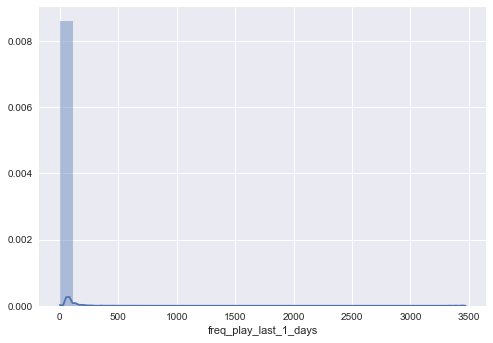

In [24]:
#df_churn.quantile(0.999)
import seaborn as sns
sns.distplot(df_churn.freq_play_last_1_days,bins=30)

In [25]:
df_churn=df_churn.loc[df_churn['freq_play_last_1_days']<500,:]

In [26]:
df_churn.describe()

,uid,churn,freq_play_last_1_days,freq_play_last_3_days,freq_play_last_7_days,freq_play_last_14_days,freq_play_last_20_days,freq_play_last_25_days,freq_download_last_1_days,freq_download_last_3_days,...,freq_download_last_25_days,freq_search_last_1_days,freq_search_last_3_days,freq_search_last_7_days,freq_search_last_14_days,freq_search_last_20_days,freq_search_last_25_days,recencyplay_day,recencydownload_day,recencysearch_day
count,3.819400e+04,38194.000000,38194.000000,38194.000000,38194.000000,38194.000000,38194.00000,38194.000000,38194.000000,38194.000000,...,38194.000000,38194.000000,38194.000000,38194.000000,38194.000000,38194.000000,38194.000000,38194.000000,15866.000000,23210.000000
mean,1.673949e+08,0.500079,4.333874,13.624941,30.124339,63.785202,90.92834,121.927109,0.123213,0.395272,...,4.638189,0.180002,0.425617,1.397994,3.354768,4.879458,6.740771,14.459941,18.004223,15.168706
std,1.027042e+07,0.500007,18.079741,50.603541,95.397577,177.194082,240.11382,305.665238,2.347220,6.455671,...,38.010673,1.751656,2.743063,6.294892,12.600025,16.057824,20.818619,11.527497,10.368747,10.757872
min,2.506910e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.680106e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,4.927083
50%,1.684594e+08,1.000000,0.000000,0.000000,0.000000,2.000000,8.00000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,20.000000,13.708333
75%,1.687636e+08,1.000000,0.000000,3.000000,18.000000,51.000000,81.00000,118.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,5.000000,28.000000,29.000000,27.083333
max,1.692480e+08,1.000000,469.000000,2457.000000,3128.000000,6275.000000,9274.00000,14614.000000,188.000000,877.000000,...,2975.000000,164.000000,195.000000,404.000000,609.000000,762.000000,869.000000,30.000000,30.000000,29.958333


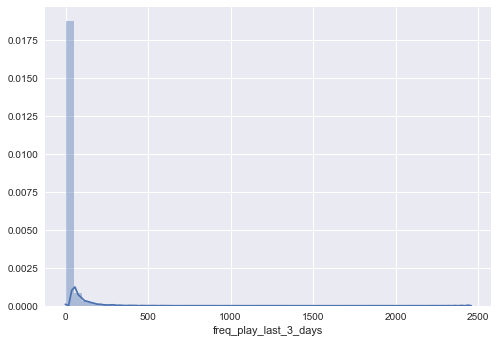

In [27]:
sns.distplot(df_churn.freq_play_last_3_days,bins=50)

In [28]:
df_churn=df_churn.loc[df_churn['freq_play_last_3_days']<1000,:]

In [29]:
df_churn.describe()

,uid,churn,freq_play_last_1_days,freq_play_last_3_days,freq_play_last_7_days,freq_play_last_14_days,freq_play_last_20_days,freq_play_last_25_days,freq_download_last_1_days,freq_download_last_3_days,...,freq_download_last_25_days,freq_search_last_1_days,freq_search_last_3_days,freq_search_last_7_days,freq_search_last_14_days,freq_search_last_20_days,freq_search_last_25_days,recencyplay_day,recencydownload_day,recencysearch_day
count,3.818200e+04,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,...,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,38182.000000,15860.000000,23201.000000
mean,1.673951e+08,0.500210,4.239511,13.190587,29.426746,62.672594,89.578257,120.389189,0.123252,0.394008,...,4.623304,0.180032,0.425462,1.396312,3.351055,4.874129,6.732937,14.464119,18.005422,15.170614
std,1.027184e+07,0.500007,17.034480,43.434409,86.279397,164.253877,225.139206,290.015918,2.347588,6.451278,...,37.945418,1.751923,2.743046,6.286876,12.583200,16.025999,20.775342,11.526896,10.367926,10.758471
min,2.506910e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.680107e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,4.958333
50%,1.684594e+08,1.000000,0.000000,0.000000,0.000000,2.000000,8.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,20.000000,13.708333
75%,1.687636e+08,1.000000,0.000000,3.000000,18.000000,51.000000,81.000000,118.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,5.000000,28.000000,29.000000,27.083333
max,1.692480e+08,1.000000,382.000000,965.000000,2798.000000,3568.000000,9274.000000,14614.000000,188.000000,877.000000,...,2975.000000,164.000000,195.000000,404.000000,609.000000,762.000000,869.000000,30.000000,30.000000,29.958333


In [30]:
for feat in ['recencydownload_day', 'recencysearch_day']:
    df_churn[feat]=df_churn[feat].fillna(100)

In [31]:
df_churn['recencydownload_day'].max()

100.0

# Build Logistic Regression Model

### Define Features and Target

In [32]:
selected_features=df_churn.columns.tolist()
selected_features.remove('uid')
selected_features.remove('churn')
#selected_features.remove('recencydownload_day')
#selected_features.remove('recencysearch_day')
target='churn'


In [33]:
X=df_churn[selected_features]
y=df_churn['churn']

In [34]:
X.shape

(38182, 21)

In [35]:
y

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
38170    1
38171    1
38172    1
38173    1
38174    1
38175    1
38176    1
38177    1
38178    1
38179    1
38180    1
38181    1
38182    1
38183    1
38184    1
38185    1
38186    1
38187    1
38188    1
38189    1
38190    1
38191    1
38192    1
38193    1
38194    1
38195    1
38196    1
38197    1
38198    1
38199    1
Name: churn, Length: 38182, dtype: int64

#### Let's Train-test split the data!

In [36]:
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Min-max scaling

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

### Logistic Regression model using sklearn


In [38]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize model by providing parameters
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(C=1.0, penalty='l2')

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred = clf.predict(X_train)
p_train_pred = clf.predict_proba(X_train)[:,1]

# Make predictions on test data
y_test_pred = clf.predict(X_test)
p_test_pred = clf.predict_proba(X_test)[:,1]

### Calculate the metric scores for the model


In [39]:
# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [40]:
import pandas as pd
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

              train      test
metrics                      
AUC        0.892503  0.897282
Accuracy   0.814667  0.818515
Precision  0.821390  0.831322
Recall     0.801541  0.810072
f1-score   0.811344  0.820559


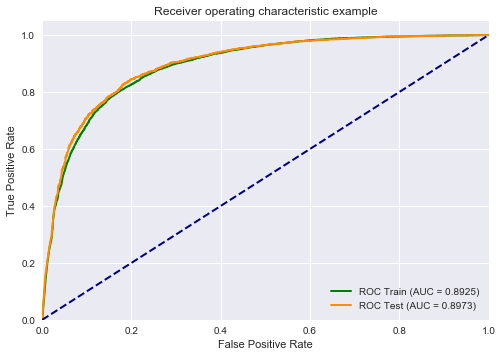

In [42]:
# print model results
get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

### Parameter Tuning with GridSearchCV

In [43]:
# GridSearch Tunning logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty='l2', fit_intercept=True)
#lr.fit(X_train, y_train)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Evaluation on Test Set

In [44]:
# Training with best parameters
best_param=clf.best_params_

from sklearn.metrics import confusion_matrix, classification_report, roc_curve
lr = LogisticRegression(penalty='l2', fit_intercept=True,**best_param)
lr.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
# Make prediction on the training data
y_train_pred = lr.predict(X_train)
p_train_pred = lr.predict_proba(X_train)[:,1]

# Make predictions on test data
y_test_pred = lr.predict(X_test)
p_test_pred = lr.predict_proba(X_test)[:,1]

              train      test
metrics                      
AUC        0.890647  0.895600
Accuracy   0.815354  0.817991
Precision  0.824883  0.833598
Recall     0.798051  0.805470
f1-score   0.811245  0.819293


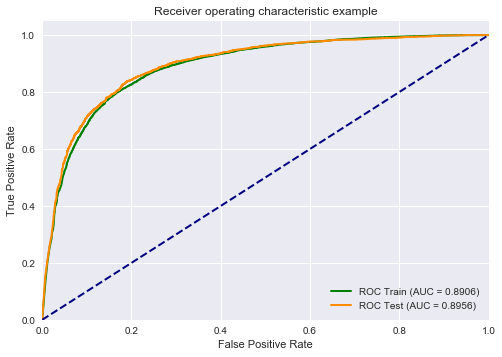

In [46]:
# The perfomance of the LR at threshold of 0.5
get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

### Understanding the estimated coeffs

In [47]:
df_coeffs = pd.DataFrame(list(zip(selected_features, lr.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs

,feature,coeff
18,recencyplay_day,3.355025
20,recencysearch_day,0.657677
19,recencydownload_day,0.359182
7,freq_download_last_3_days,-0.012225
6,freq_download_last_1_days,-0.015180
12,freq_search_last_1_days,-0.017263
8,freq_download_last_7_days,-0.018151
9,freq_download_last_14_days,-0.018194
10,freq_download_last_20_days,-0.023311
11,freq_download_last_25_days,-0.036504


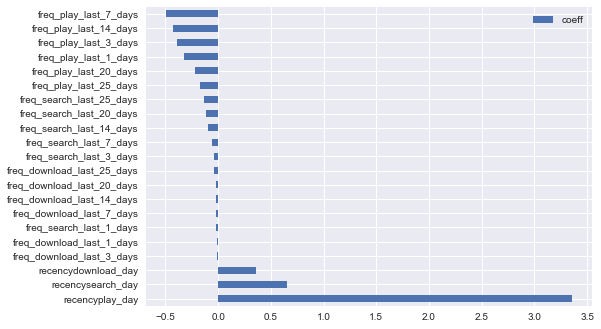

In [48]:
ax = df_coeffs.plot.barh()
t = np.arange(X.shape[1])
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

# Decision Tree

In [70]:
# define function to perform train, test, and get model performance
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)


              train      test
metrics                      
AUC        0.911140  0.897979
Accuracy   0.830054  0.821789
Precision  0.818466  0.814705
Recall     0.845789  0.844070
f1-score   0.831903  0.829127


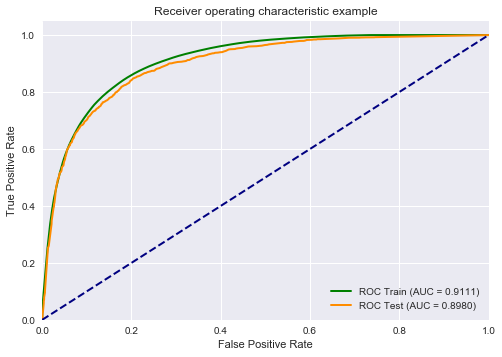

In [57]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=30,min_samples_leaf=50)
train_test_model(clf, X_train, y_train, X_test, y_test)

1. feature recencyplay_day (0.828806)
2. feature freq_play_last_3_days (0.057491)
3. feature freq_play_last_25_days (0.039504)
4. feature recencysearch_day (0.028774)
5. feature freq_play_last_20_days (0.013836)
6. feature recencydownload_day (0.010452)
7. feature freq_play_last_7_days (0.006262)
8. feature freq_play_last_14_days (0.005780)
9. feature freq_search_last_25_days (0.004755)
10. feature freq_play_last_1_days (0.001201)
11. feature freq_download_last_25_days (0.000763)
12. feature freq_search_last_14_days (0.000691)
13. feature freq_download_last_20_days (0.000604)
14. feature freq_search_last_7_days (0.000573)
15. feature freq_search_last_20_days (0.000489)
16. feature freq_download_last_14_days (0.000021)
17. feature freq_download_last_7_days (0.000000)
18. feature freq_download_last_3_days (0.000000)
19. feature freq_download_last_1_days (0.000000)
20. feature freq_search_last_1_days (0.000000)
21. feature freq_search_last_3_days (0.000000)


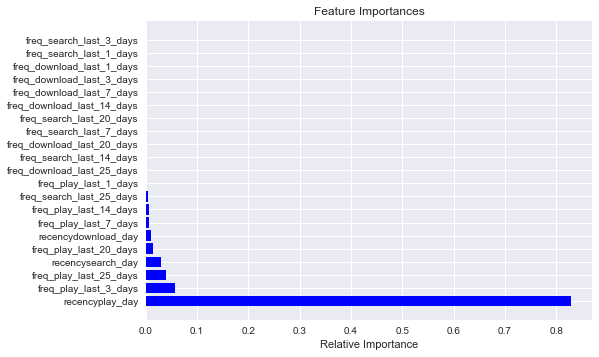

In [68]:
# Plot feature importance ranking
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, selected_features[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Random Forest


              train      test
metrics                      
AUC        0.910009  0.905059
Accuracy   0.830349  0.827812
Precision  0.820653  0.825031
Recall     0.843024  0.842536
f1-score   0.831688  0.833692


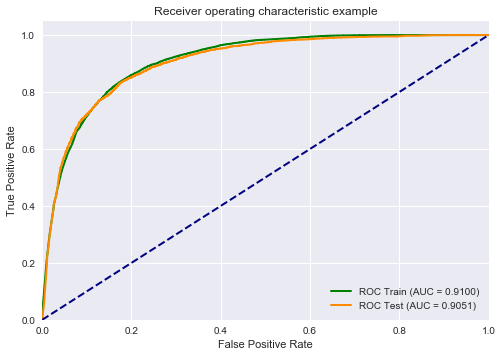

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Choose some parameter combinations to try
parameters = {'n_estimators': 100,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 30,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

1. feature recencyplay_day (0.160753)
2. feature recencysearch_day (0.159503)
3. feature freq_play_last_25_days (0.155298)
4. feature freq_play_last_20_days (0.109637)
5. feature freq_play_last_14_days (0.087608)
6. feature recencydownload_day (0.062280)
7. feature freq_play_last_7_days (0.056459)
8. feature freq_search_last_25_days (0.047451)
9. feature freq_play_last_3_days (0.030420)
10. feature freq_search_last_20_days (0.027516)
11. feature freq_download_last_25_days (0.024744)
12. feature freq_search_last_14_days (0.019404)
13. feature freq_play_last_1_days (0.014585)
14. feature freq_download_last_20_days (0.013250)
15. feature freq_search_last_7_days (0.011016)
16. feature freq_download_last_14_days (0.009344)
17. feature freq_download_last_7_days (0.004117)
18. feature freq_search_last_3_days (0.003003)
19. feature freq_download_last_3_days (0.001569)
20. feature freq_search_last_1_days (0.001435)
21. feature freq_download_last_1_days (0.000609)


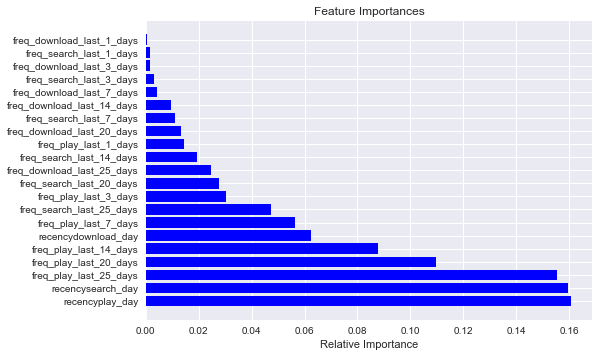

In [75]:
# Plot feature importance ranking
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, selected_features[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Gradient Boosting Trees

              train      test
metrics                      
AUC        0.925699  0.899532
Accuracy   0.853626  0.821396
Precision  0.840970  0.818341
Recall     0.870152  0.837168
f1-score   0.855312  0.827647


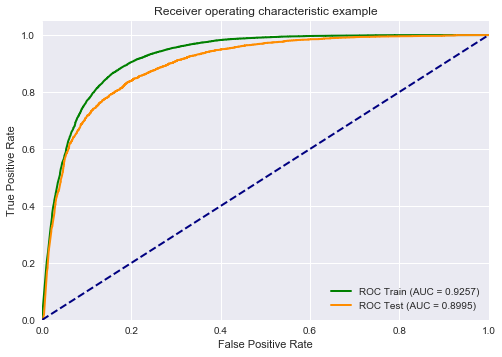

In [76]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.2,
    'random_state': 42
}

clf = GradientBoostingClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

1. feature recencyplay_day (0.180516)
2. feature freq_play_last_25_days (0.135372)
3. feature recencysearch_day (0.119217)
4. feature freq_play_last_14_days (0.100129)
5. feature freq_play_last_20_days (0.086025)
6. feature freq_play_last_7_days (0.066166)
7. feature recencydownload_day (0.049932)
8. feature freq_search_last_25_days (0.046534)
9. feature freq_download_last_25_days (0.036844)
10. feature freq_search_last_20_days (0.032253)
11. feature freq_play_last_3_days (0.028943)
12. feature freq_search_last_14_days (0.024629)
13. feature freq_download_last_14_days (0.018248)
14. feature freq_search_last_7_days (0.018237)
15. feature freq_play_last_1_days (0.014289)
16. feature freq_download_last_20_days (0.013237)
17. feature freq_search_last_3_days (0.012129)
18. feature freq_download_last_7_days (0.007022)
19. feature freq_download_last_3_days (0.004512)
20. feature freq_download_last_1_days (0.002992)
21. feature freq_search_last_1_days (0.002773)


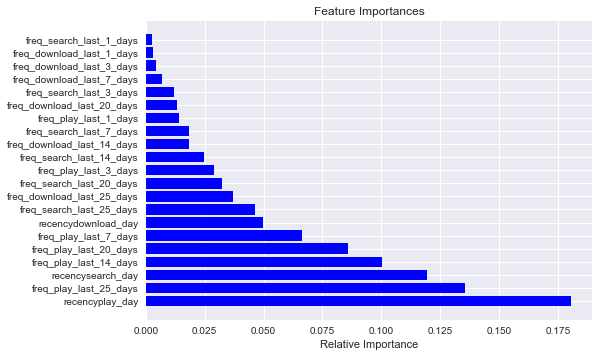

In [77]:
# Plot feature importance ranking
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, selected_features[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Neural Network

              train      test
metrics                      
AUC        0.894090  0.898711
Accuracy   0.815322  0.821920
Precision  0.803819  0.817097
Recall     0.831501  0.840491
f1-score   0.817426  0.828629


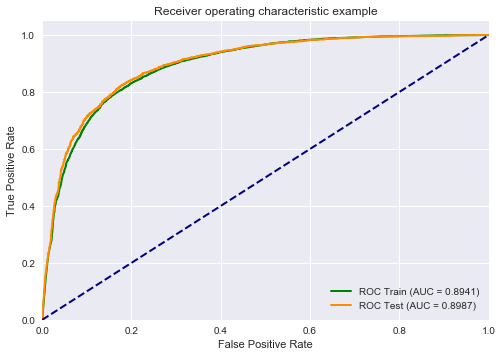

In [80]:
from sklearn.neural_network import MLPClassifier

# Choose some parameter combinations to try
parameters = {
    'solver':'adam', 
    'activation':'relu',
    'alpha':1e-5, #increase alpha->increase penalty :: http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py
    'hidden_layer_sizes':(20,40,20), 
    'learning_rate':'adaptive',
    'random_state':1
    }
clf = MLPClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

# HyperParameter Tuning: Grid Search for Random Forest

In [81]:
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [100,150,200], 
              'max_features': ['auto','sqrt'], 
              'criterion': ['gini'],
              'max_depth': [5,10,15,20], 
              'min_samples_split': [2],
              'min_samples_leaf': [10,20,30],
              'n_jobs':[-1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)

# Run the grid search
# read theory
grid_obj = GridSearchCV(clf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              train      test
metrics                      
AUC        0.914211  0.905565
Accuracy   0.834114  0.826372
Precision  0.826241  0.827011
Recall     0.843814  0.835890
f1-score   0.834935  0.831426


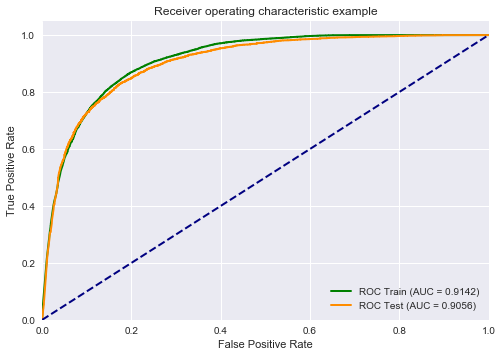

In [82]:
# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)